---

## Winged Horses with a Generative Adversarial Network

### References
#### Code
- https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/4.%20WGAN-GP, released under the MIT license.<br/>

#### Papers
- Radford, A., Metz, L. and Chintala, S., 2015. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.
- Arjovsky, M., Chintala, S. and Bottou, L., 2017, July. Wasserstein generative adversarial networks. In International conference on machine learning (pp. 214-223). PMLR.
- Gulrajani, I., Ahmed, F., Arjovsky, M., Dumoulin, V. and Courville, A., 2017. Improved training of wasserstein gans. arXiv preprint arXiv:1704.00028.

#### Other
- https://www.alexirpan.com/2017/02/22/wasserstein-gan.html

---

### Imports

In [ ]:
import numpy as np
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import tqdm

---

### Configuration and Hyperparameters

In [ ]:
# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

# Configuration
EPOCHS = 1000
IMAGE_SIZE = (64, 64)

DATASET = "stl10"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    PATH = "drive/My Drive/training"
    print(f"Using Google Drive (path '{PATH}') for storage.")
except ImportError:
    drive = None
    PATH = "data/training"
    print(f"Using local disk (path '{PATH}') for storage.")

---

### Helper Functions

In [ ]:
# Output an image using matplotlib
def show_image(image):
    plt.rcParams["figure.dpi"] = 175
    plt.grid(False)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.show()


def gradient_penalty(crit, re, fa, device="cpu"):
    batch_size, c, h, w = re.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = re * alpha + fa * (1 - alpha)

    # Calculate critic scores
    mixed_scores = crit(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    g_p = torch.mean((gradient_norm - 1) ** 2)
    return g_p


def save_checkpoint(g, c, epc, filename):
    print("=> Saving checkpoint")
    torch.save({"gen": g.state_dict(), "crit": c.state_dict(), "epoch": epc}, filename)


def load_checkpoint(checkpoint, g, c):
    print("=> Loading checkpoint")
    g.load_state_dict(checkpoint["gen"])
    c.load_state_dict(checkpoint["crit"])
    return checkpoint["epoch"]

---

### Data Loading and Sampling

In [ ]:
dataset = None
class_names = None
sampled_classes = None

transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

if DATASET == "cifar10":
    # Load and transform dataset
    dataset = torchvision.datasets.CIFAR10(
        f"{PATH}/cifar10",
        train=True,
        download=True,
        transform=transform
    )
    # Identify bird and horse label values
    class_names = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
    sampled_classes = {"bird": class_names.index("bird"), "horse": class_names.index("horse")}

    # Filter out all data not labelled as bird or horse
    labels = torch.tensor(dataset.targets)
    idx = (labels == sampled_classes["bird"]) | (labels == sampled_classes["horse"])
    dataset.targets = labels[idx]
    dataset.data = dataset.data[idx.numpy().astype(np.bool)]

elif DATASET == "stl10":
    # Load and transform dataset
    dataset = torchvision.datasets.STL10(
            f"{PATH}/stl10",
            split="train+unlabeled",
            download=True,
            transform=transform
    )
    # Identify bird and horse label values
    class_names = ("airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck")
    sampled_classes = {"bird": class_names.index("bird"), "horse": class_names.index("horse")}

    # Filter out all data not labelled as bird or horse
    labels = torch.tensor(dataset.labels)
    idx = (labels == sampled_classes["bird"]) | (labels == sampled_classes["horse"])
    dataset.labels = labels[idx]
    dataset.data = dataset.data[idx.numpy().astype(np.bool)]

# Create a training data loader
train_loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True
)
train_iterator = iter(train_loader)

In [ ]:
# Visualise a sample of the data
sample_images, sample_labels = next(train_iterator)
show_image(torchvision.utils.make_grid(sample_images))
print([class_names[sample_label] for sample_label in sample_labels])

---

### Define the Generator and Discriminator

In [ ]:
class CriticBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.block(x)


class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # CriticBlock(in_channels, out_channels, kernel_size, stride, padding)
            CriticBlock(features_d, features_d * 2, 4, 2, 1),
            CriticBlock(features_d * 2, features_d * 4, 4, 2, 1),
            CriticBlock(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def forward(self, x):
        return self.disc(x)


class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.block = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super().__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            GeneratorBlock(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            GeneratorBlock(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            GeneratorBlock(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            GeneratorBlock(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

---

### Training

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(DEVICE)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(DEVICE)
initialize_weights(gen)
initialize_weights(critic)

# Initialize optimiser
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(64, Z_DIM, 1, 1).to(DEVICE)
writer_real = SummaryWriter(f"logs/GAN_{DATASET}/real")
writer_fake = SummaryWriter(f"logs/GAN_{DATASET}/fake")
step = 0

gen.train()
critic.train()

 93%|█████████▎| 14/15 [00:03<00:00,  3.94it/s]


Epoch [1/1000] Loss C: -22.5802, loss G: 150.6447
=> Saving checkpoint
Epoch [2/1000] Loss C: -17.5152, loss G: 145.8328
=> Saving checkpoint
Epoch [3/1000] Loss C: -16.5575, loss G: 154.4032
=> Saving checkpoint
Epoch [4/1000] Loss C: -18.1931, loss G: 147.5038
=> Saving checkpoint
Epoch [5/1000] Loss C: -17.2685, loss G: 152.9471
=> Saving checkpoint
Epoch [6/1000] Loss C: -18.6719, loss G: 147.3463
=> Saving checkpoint
Epoch [7/1000] Loss C: -16.9538, loss G: 146.6669
=> Saving checkpoint
Epoch [8/1000] Loss C: -17.8363, loss G: 146.2858
=> Saving checkpoint
Epoch [9/1000] Loss C: -19.3095, loss G: 147.6236
=> Saving checkpoint
Epoch [10/1000] Loss C: -19.4465, loss G: 150.4583
=> Saving checkpoint
Epoch [11/1000] Loss C: -17.9263, loss G: 153.9603
=> Saving checkpoint
Epoch [12/1000] Loss C: -18.6611, loss G: 151.2012
=> Saving checkpoint
Epoch [13/1000] Loss C: -19.3998, loss G: 149.8255
=> Saving checkpoint
Epoch [14/1000] Loss C: -20.0044, loss G: 151.7794
=> Saving checkpoint
E

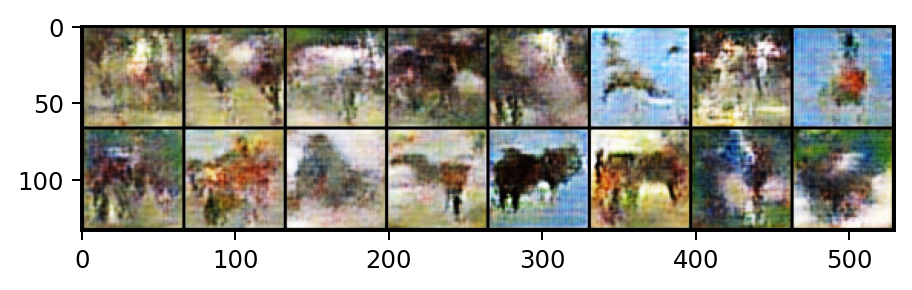

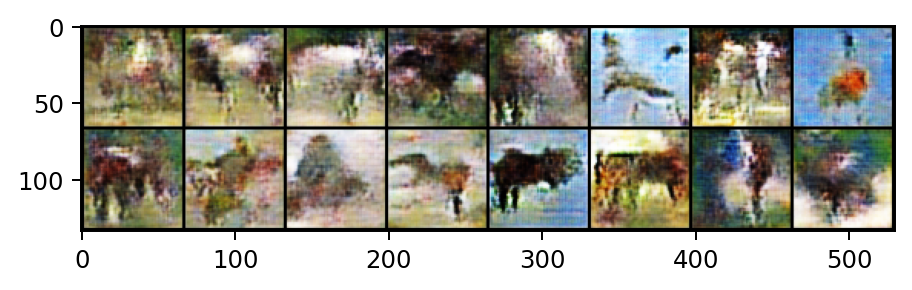

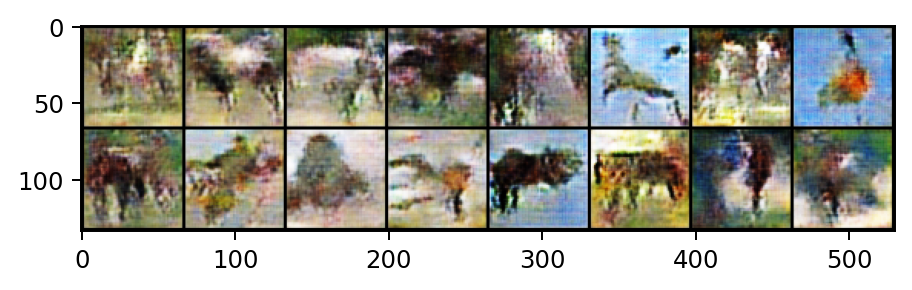

KeyboardInterrupt: 

In [9]:
for epoch in range(EPOCHS):
    l_c = None
    l_g = None
    last_real = None

    for batch_idx, (real, _) in enumerate(tqdm.tqdm(train_loader)):
        last_real = real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=DEVICE)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            l_c = loss_critic.cpu().detach().item()
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        l_g = loss_gen.cpu().detach().item()
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(
        f"Epoch [{epoch + 1}/{EPOCHS}] "
        f"Loss C: {l_c:.4f}, loss G: {l_g:.4f}"
    )

    save_checkpoint(
        gen, critic, epoch,
        f"checkpoints/pegasus1-{epoch}.chkpt"
    )

    with torch.no_grad():
        fake = gen(fixed_noise)
        # take out (up to) 16 examples
        img_grid_real = torchvision.utils.make_grid(last_real[:16], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        if not epoch % 50:
            show_image(img_grid_fake.cpu())

    step += 1

---

### Sampling

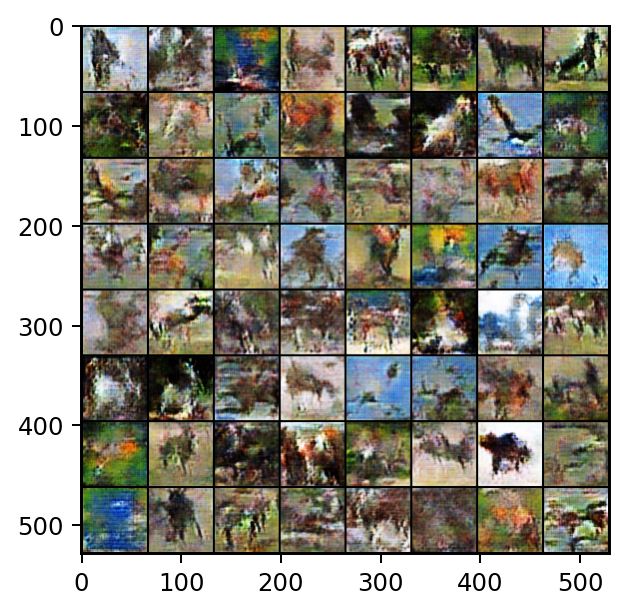

In [19]:
with torch.no_grad():
    noise = torch.randn(64, Z_DIM, 1, 1, device=DEVICE)
    generated = gen(noise)
    grid = torchvision.utils.make_grid(generated.cpu().detach(), normalize=True)
    show_image(grid)